# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\levin\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


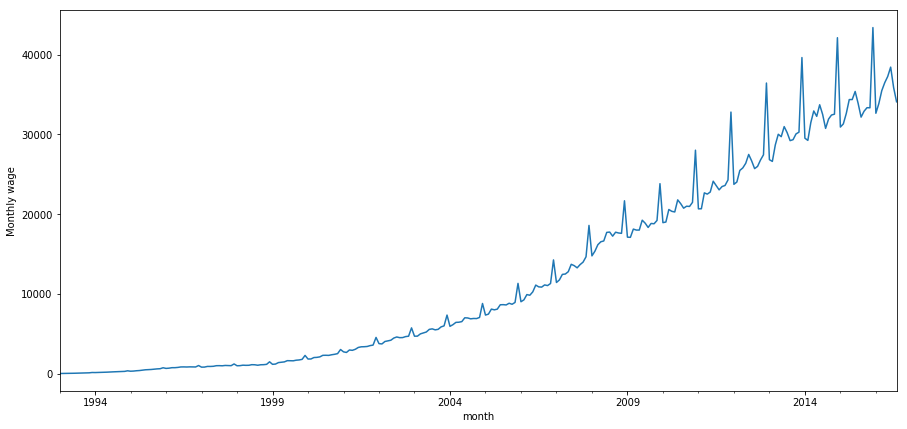

In [9]:
wage = pd.read_csv('wage.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel('Monthly wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


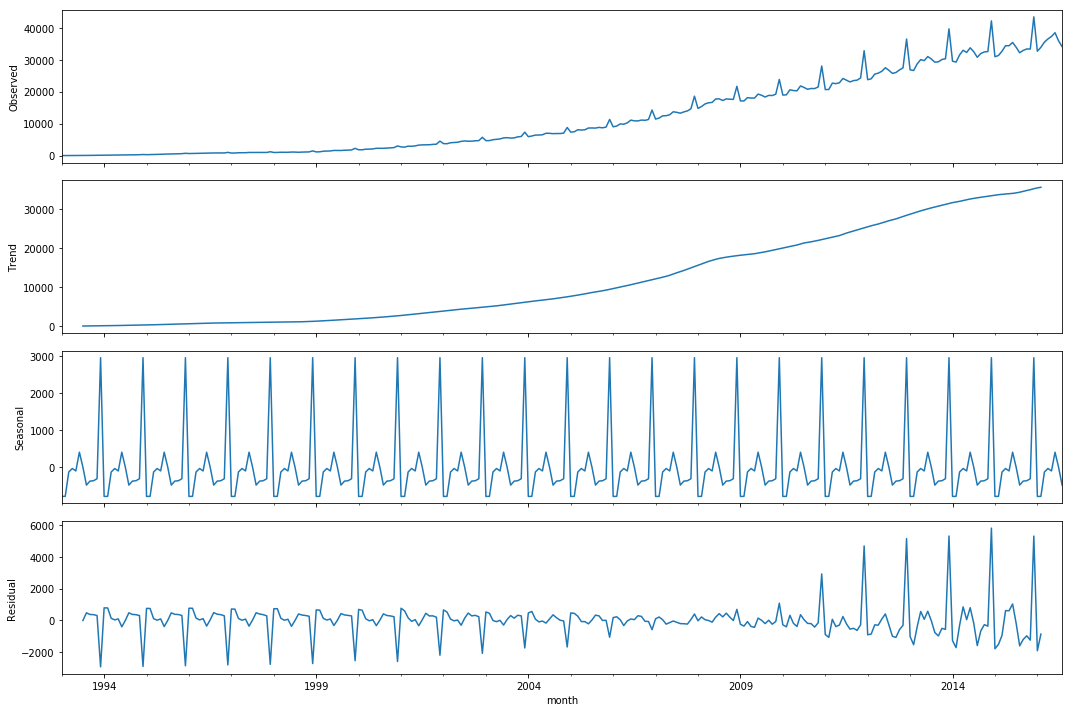

In [10]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:


Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


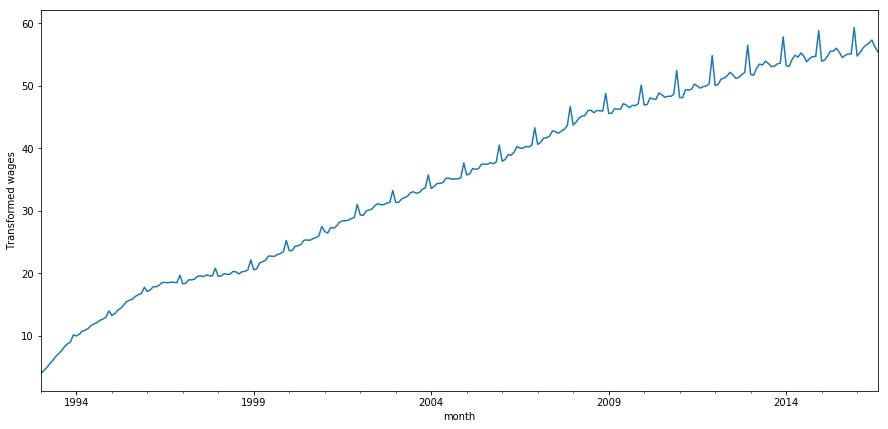

In [11]:
wage['wages_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.wages_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wages_box)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности,в данных очевиден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:


Критерий Дики-Фуллера: p=0.014697


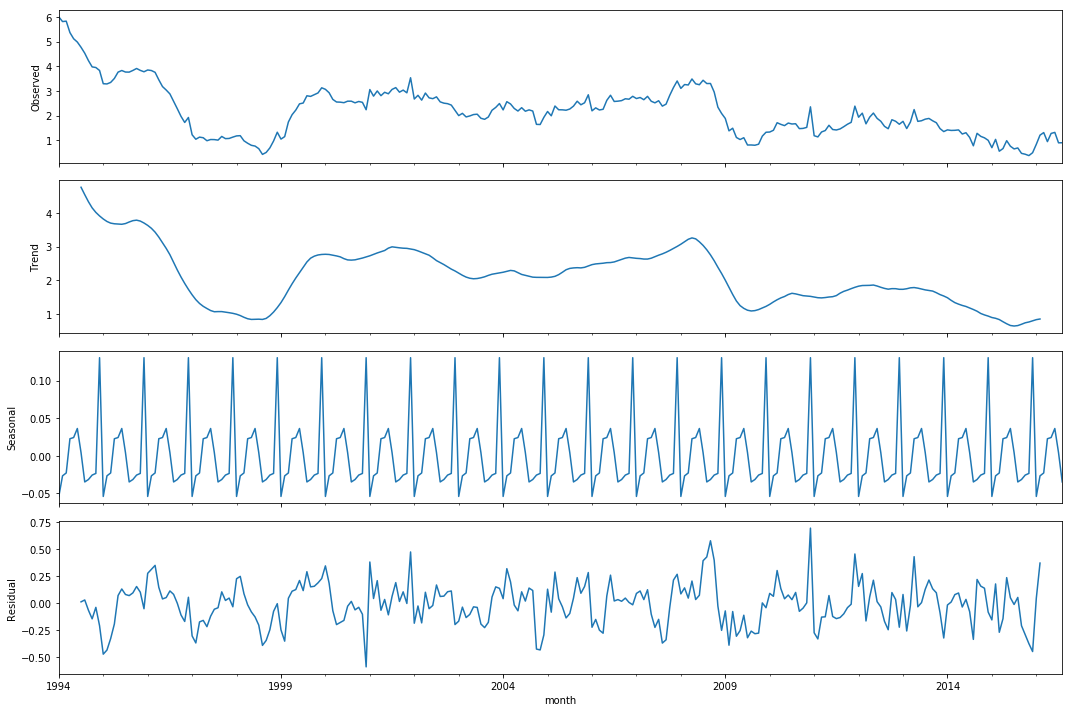

In [12]:
wage['wages_box_diff'] = wage.wages_box - wage.wages_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wages_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wages_box_diff[12:])[1])

Критерий Дики-Фуллера по прежнему не позволяет отклонить гипотезу о нестационарности ряда. Попробуем добавить обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


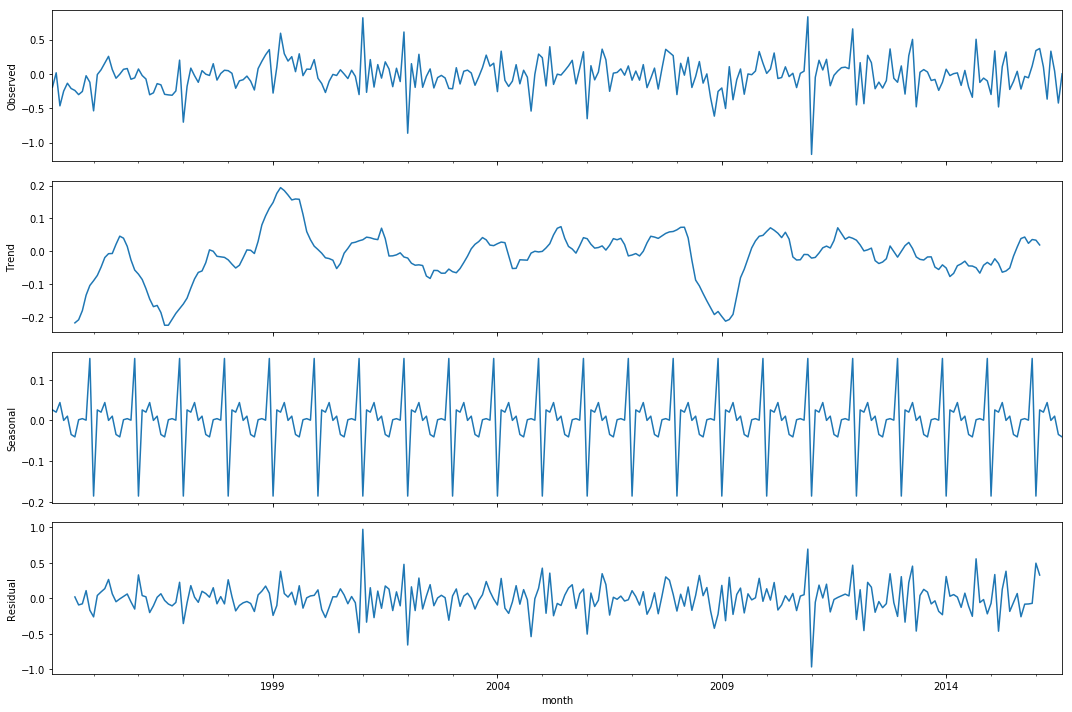

In [13]:
wage['wages_box_diff2'] = wage.wages_box_diff - wage.wages_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.wages_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wages_box_diff2[13:])[1])

Гипотеза о нестационарности отвергается, тренд ликвидирован.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:


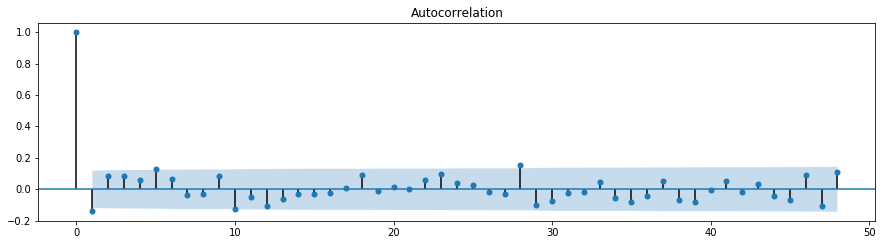

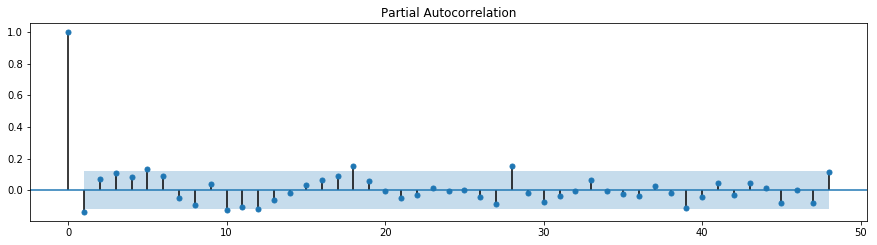

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wages_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=4, p=11

In [27]:
ps = range(0, 12)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0,1)

In [28]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wages_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 3, 0)
wrong parameters: (2, 1, 4, 0)
Wall time: 7min 50s


In [30]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters       aic
105  (11, 0, 1, 0) -9.662085
110  (11, 1, 1, 0) -9.509328
106  (11, 0, 2, 0) -7.929213
55    (6, 0, 1, 0) -7.552970
111  (11, 1, 2, 0) -7.517508


In [31]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                           wages_box   No. Observations:                  284
Model:             SARIMAX(11, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  17.831
Date:                             Thu, 13 Jun 2019   AIC                             -9.662
Time:                                     00:42:59   BIC                             37.775
Sample:                                 01-01-1993   HQIC                             9.356
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2176      0.048     -4.567      0.000      -0.311      -0.124
ar.L2          0.0205      

Остатки:

Критерий Стьюдента: p=0.131472
Критерий Дики-Фуллера: p=0.000000


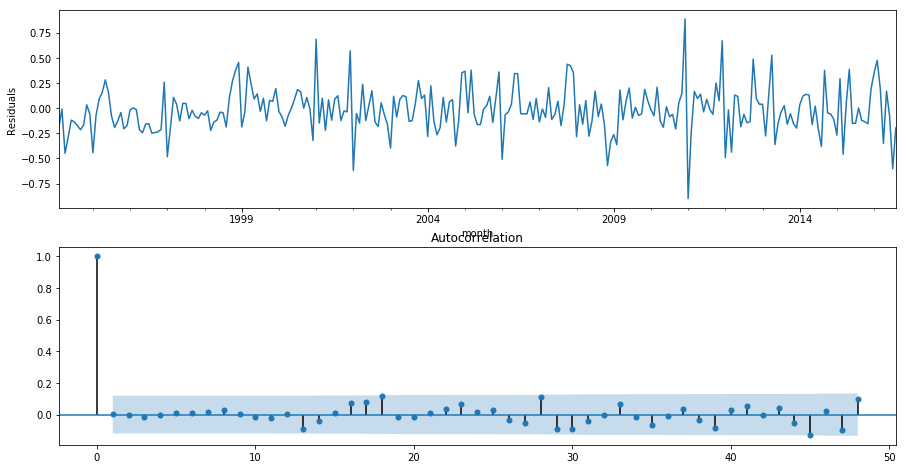

In [32]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

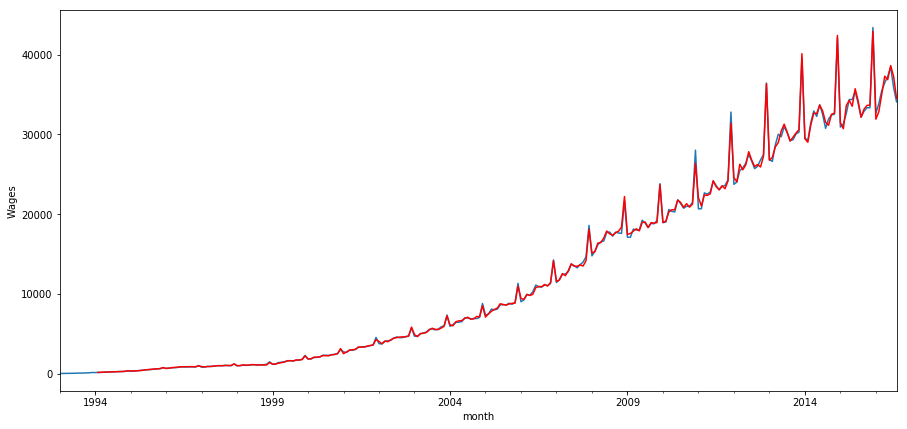

In [34]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Wages')
pylab.show()

### Прогноз

In [35]:
wage

,WAG_C_M,wages_box,wages_box_diff,wages_box_diff2,model
month,,,,,
1993-01-01,15.3,3.990393,NaN,NaN,1.000000
1993-02-01,19.1,4.458758,NaN,NaN,15.300000
1993-03-01,23.6,4.931635,NaN,NaN,19.100000
1993-04-01,30.6,5.549430,NaN,NaN,23.600000
1993-05-01,37.5,6.063406,NaN,NaN,30.600000
1993-06-01,47.4,6.690719,NaN,NaN,37.500000
1993-07-01,56.0,7.161310,NaN,NaN,47.400000
1993-08-01,65.4,7.618224,NaN,NaN,56.000000
1993-09-01,80.9,8.275619,NaN,NaN,65.400000


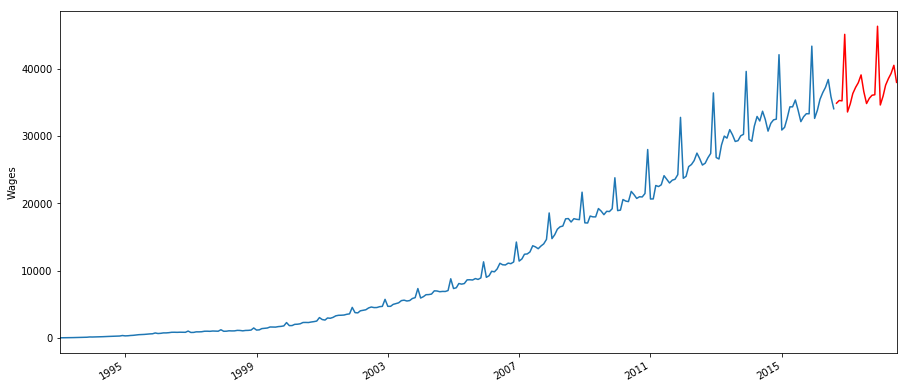

In [36]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()